In [1]:
import snappy
from snappy import ProductIO
import datetime
import sys
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from netCDF4 import Dataset
from scipy import signal
import cv2
import calibrate
import direction
import cmod5n
from mpl_toolkits.basemap import Basemap
%matplotlib inline


In [2]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T141604_20170518T141629_016637_01B9B7_C40C.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]

In [5]:
print(np.max(lat))
print(np.min(lat))
print(np.max(lon))
print(np.min(lon))

37.712
35.8095
-121.767
-124.916


/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


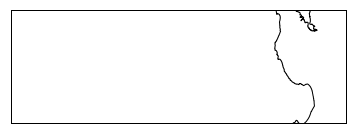

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
map_ = Basemap(projection='stere',lat_0=90,lon_0=-105,\
            llcrnrlat=35.8095 ,urcrnrlat=37.712,\
            llcrnrlon=-124.916,urcrnrlon=-121.767, resolution='f', ax=ax)
map_.drawmapboundary(fill_color='white')   # 绘制边界
map_.drawcoastlines() 
map_.imshow(im, origin='upper', cmap='gray')
plt.show()

In [6]:
map_(-122.881, 37.363)

(285512.8432971835, 131022.45500792935)

In [ ]:
from PIL import Image

In [10]:
sigma_vv = data.variables['Sigma0_VV'][:]

In [3]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T141604_20170518T141629_016637_01B9B7_C40C.nc')
sigma_vv = data.variables['Sigma0_VV'][:]
sub = sigma_vv[8000:15000, 10000:24000]
ndbc_dire = (190-318+90)%360


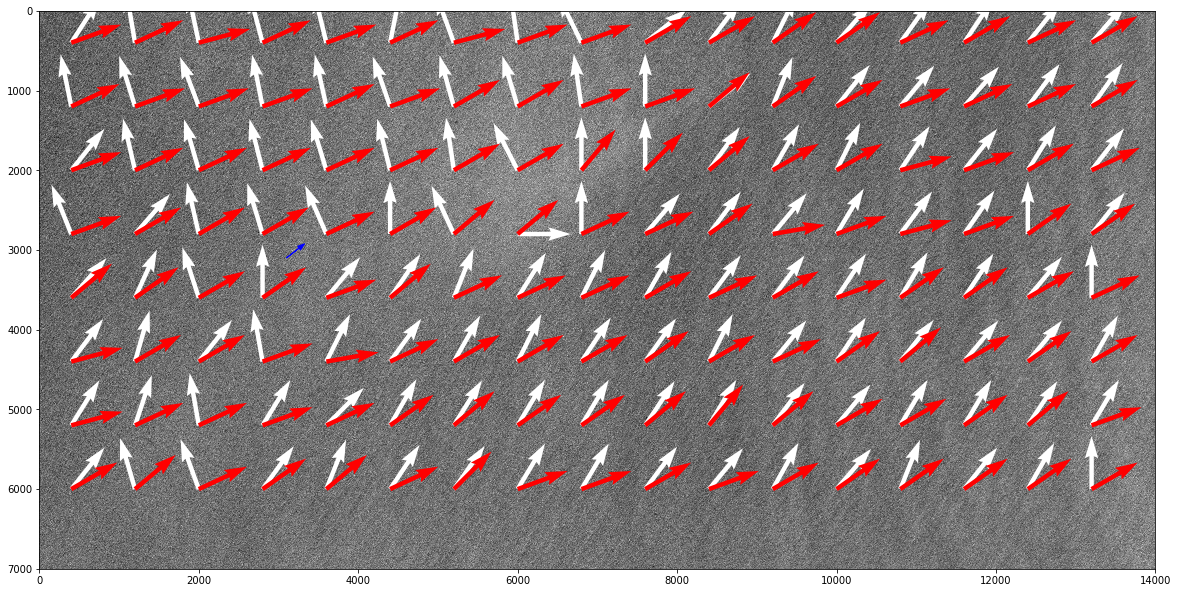

In [5]:
dire_ = direction.get_dir(sub, sub_size=800, remove_ambi = True, ndbc_= ndbc_dire)
direction.plot_dir(dire_, sub, sub_size=800, file_name='./newwind_4.eps')
plt.arrow(3100, 3100, 200*np.cos(ndbc_dire/180*np.pi), 200*np.sin(ndbc_dire/180*np.pi), color=(0, 0, 1),width=0.04,head_width=60)

In [2]:
#median filter based on background filed b select the best result between w1 and w2, which have the same shape
#w1 is the initila wind filed
#w3 is the final wind filed
def Median_filter(w1, w2, b, filter_size):
    shape_x = w1.shape[0]
    shape_y = w1.shape[1]
    w3 = np.copy(w1)
    filter_size_h = int(filter_size/2)
    for i in np.arange(filter_size_h, shape_x-filter_size_h, filter_size_h):
        for j in np.arange(filter_size_h, shape_y-filter_size_h, filter_size_h):
            imag = w1[ i-filter_size_h:i+filter_size_h+1, j-filter_size_h:j+filter_size_h+1]
            imag1 = w2[ i-filter_size_h:i+filter_size_h+1, j-filter_size_h:j+filter_size_h+1]
            m = np.median(imag)
            for k in range(filter_size+1):
                for t in range(filter_size+1):
                    t1 = np.abs(imag1[k, t]-m)
                    print('t1:%f'%t1)
                    t2 = np.abs(imag[k, t]-m)
                    print('t2:%f'%t2)
                    if t1>180 :
                        t1=360-t1
                    if t2>180:
                        t2=360-t2
                    if t1<t2:
                        w3[i-filter_size_h+k, j-filter_size_h+t]= imag1[k, t]
        if (shape_y-filter_size_h)%(filter_size_h+1)==0:
            continue
        imag = w1[i-filter_size_h:i+filter_size_h+1, j+filter_size_h+1:]
        imag1 = w2[ i-filter_size_h:i+filter_size_h+1,j+filter_size_h+1:]
        m = np.median(imag)
        for k in range(filter_size+1):
            for t in range((shape_y-filter_size_h)%(filter_size_h+1)):
                t1 = np.abs(imag1[k, t]-m)
                t2 = np.abs(imag[k, t]-m)
                if t1>180 :
                    t1=360-t1
                if t2>180:
                    t2=360-t2
                if t1<t2:
                    w3[i-filter_size_h+k, j+filter_size_h+1+t]= imag1[k, t]
    if (shape_x-filter_size_h)%(filter_size_h+1)!=0:
        for e in np.arange(filter_size_h, shape_y-filter_size_h, filter_size_h):
            imag = w1[i+filter_size_h+1:, e-filter_size_h:j+filter_size_h+1]
            imag1 = w2[i+filter_size_h+1:, e-filter_size_h:j+filter_size_h+1]
            m = np.median(imag)
            for k in range((shape_x-filter_size_h)%(filter_size_h+1)):
                for t in range(filter_size+1):
                    t1 = np.abs(imag1[k, t]-m)
                    t2 = np.abs(imag[k, t]-m)
                    if t1>180 :
                        t1=360-t1
                    if t2>180:
                        t2=360-t2
                    if t1<t2:
                        w3[i+filter_size_h+k+1, e-filter_size_h+t]= imag1[k, t]
        if (shape_y-filter_size_h)%(filter_size_h+1)!=0:
            imag = w1[i+filter_size_h+1:, j+filter_size_h+1:]
            imag1 = w2[i+filter_size_h+1:, j+filter_size_h+1:]
            m = np.median(imag)
            for k in range((shape_x-filter_size_h)%(filter_size_h+1)):
                    for t in range((shape_y-filter_size_h)%(filter_size_h+1)):
                        t1 = np.abs(imag1[k, t]-m)
                        t2 = np.abs(imag[k, t]-m)
                        if t1>180 :
                            t1=360-t1
                        if t2>180:
                            t2=360-t2
                        if t1<t2:
                            w3[i+filter_size_h+k+1, j+filter_size_h+t+1]= imag1[k, t]
    return w3

In [8]:
ww3 = Median_filter(w1=ww3, w2=dire_[1], b=ndbc_dire, filter_size=8)

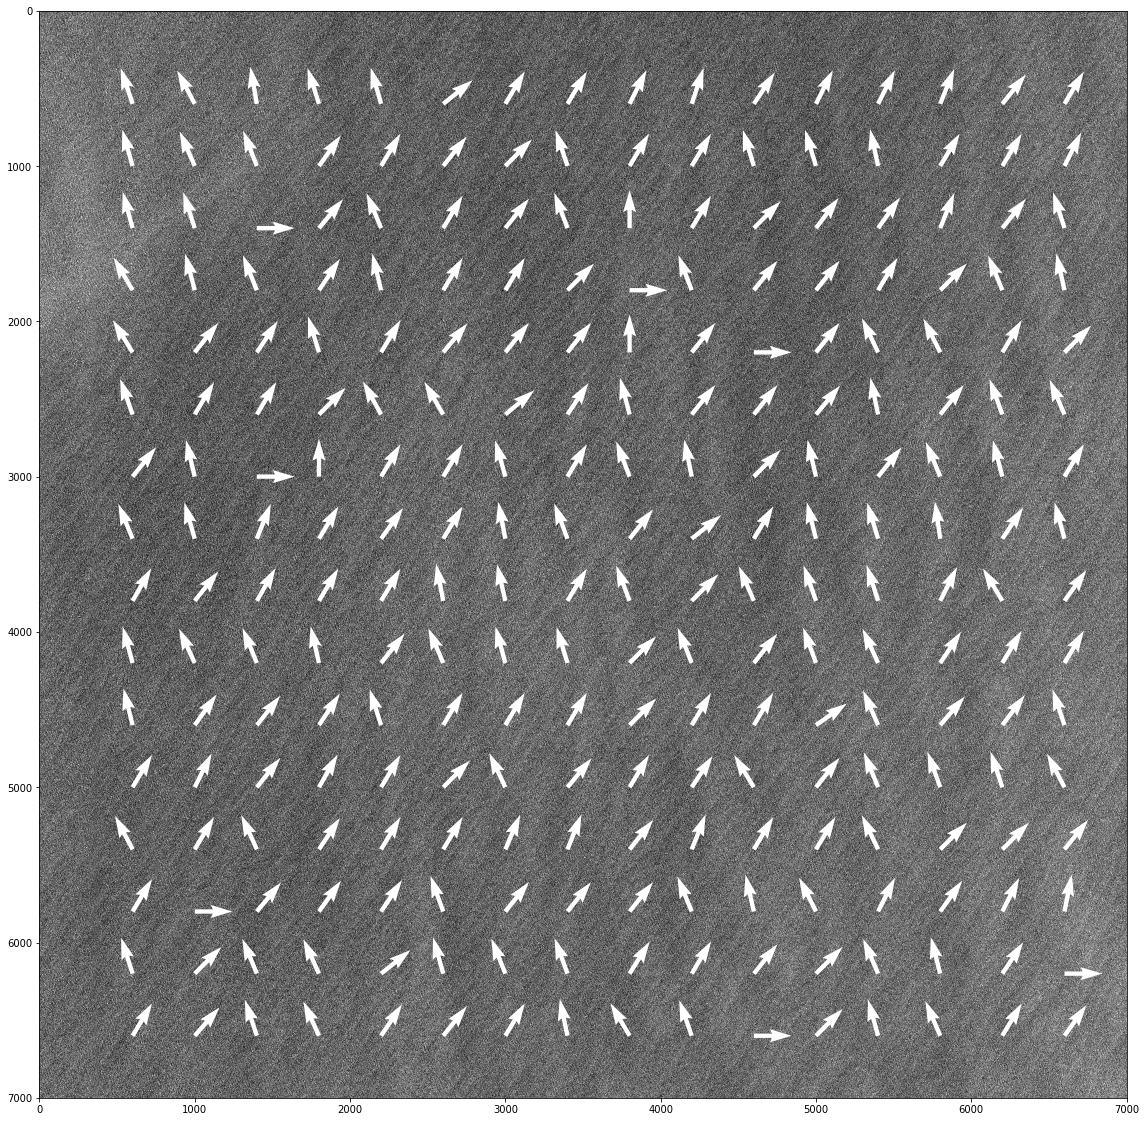

In [9]:
direction.plot_dir((ww3,), sub[:, 7000:], sub_size=400, file_name='./newwind_4h.eps')

In [11]:
for i in np.arange(3, 10, 2):
    print(i)

3
5
7
9


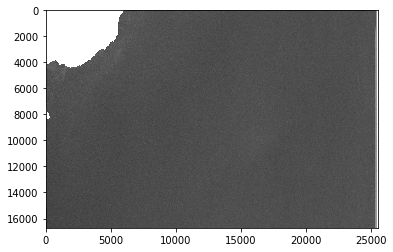

In [18]:
plt.imshow(-10*np.log10(sigma_vv), 'gray')

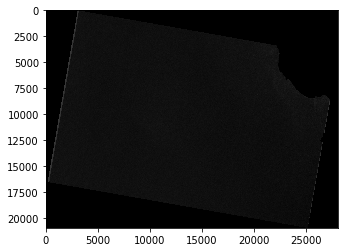

In [24]:
plt.imshow(out)

In [12]:
10.9 

In [4]:
360-8.83

351.17

In [31]:
im.shape

(20895, 28045)

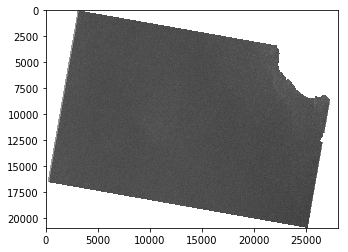

In [14]:
plt.imshow(-10*np.log10(im), 'gray')

In [36]:
im[0, ]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [39]:
im[15000,15000]

9.196414

In [38]:
sigma_vv[0, 0]

5.6780424e-05

In [40]:
im[im<0]=0

In [42]:
np.max(im)

106.92052

In [43]:
im[im==0]=100

In [6]:
map_ = Basemap(projection='stere',lat_0=np.max(lat),lon_0=np.min(lon),\
            llcrnrlat=np.min(lat) ,urcrnrlat=np.max(lat),\
            llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), resolution='f')

In [16]:
sar_ndbc = pd.read_csv('./sar_ndbc.csv')

In [19]:
sar_ndbc[sar_ndbc['ndbc']==ndbc_name][sar_ndbc['sar_name']==sar_name]

/Users/yangchao/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Unnamed: 0   ascending   ndbc  ndbc_dir  ndbc_height  ndbc_speed  \
242         242  Descending  46012       318          5.0         6.6   

                                              sar_name  
242  S1A_IW_GRDH_1SDV_20170518T141604_20170518T1416...

In [20]:
ndbc_i = pd.read_csv('/Volumes/Yangchao/data/ndbc_station_information.csv')

In [25]:
line = ndbc_i[ndbc_i['name']=='46012']

In [27]:
line.lon, line.lat

(524   -122.881
 Name: lon, dtype: float64, 524    37.363
 Name: lat, dtype: float64)

In [29]:
np.min(lat)

35.809471

In [30]:
np.max(lat)

37.712006

In [31]:
np.min(lon)

-124.91585

In [32]:
np.max(lon)

-121.76707

In [34]:
0.881*60

52.86

In [35]:
0.86*60

51.6

In [36]:
0.363*60

21.78

In [ ]:
7824 12046

In [37]:
0.78*60

46.800000000000004

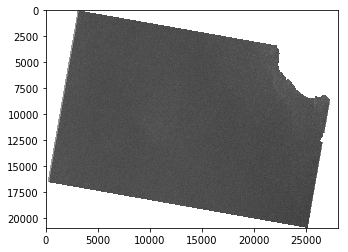

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(-10*np.log10(im), 'gray')

In [2]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T141604_20170518T141629_016637_01B9B7_C40C.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]

In [15]:
from PIL import Image
image = Image.fromarray(sigma_vv)
out = image.transpose(Image.FLIP_LEFT_RIGHT)
out = out.rotate(351, expand=1)
im = np.array(out)

In [16]:
map_ = Basemap(projection='stere',lat_0=np.max(lat),lon_0=np.min(lon),\
            llcrnrlat=np.min(lat) ,urcrnrlat=np.max(lat),\
            llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), resolution='f')


In [69]:
x, y = map_(-122.881,  37.363)
sub_lat = lat[9800:14210,15950:20360]
sub_lon = lon[9800:14210,15950:20360]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0], sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0], sub_lon[0,0]]
xx, yy = map_(poly_lon, poly_lat)

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is d

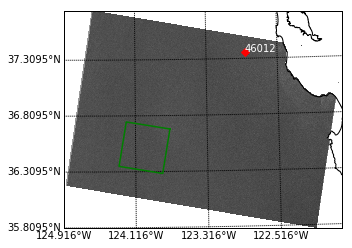

In [70]:

map_.drawcoastlines()
map_.imshow(-10*np.log10(im),origin='upper',cmap='gray')
parallels=np.arange(np.min(lat), np.max(lat), 0.5)
map_.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(lon), np.max(lon), 0.8)
map_.drawmeridians(meridians,labels=[0,0,0,1])
map_.drawmapboundary(fill_color='white')
map_.plot(int(x), int(y), marker='D', color='r')
map_.plot(np.around(xx), np.around(yy),'g-')
plt.text(int(x+10), int(y+10), '46012', color='white')
plt.savefig('./1.png', dpi=400)

In [16]:
im.shape

(20895, 28045)

In [2]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T233538_20170518T233603_016643_01B9E6_D58F.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]
from PIL import Image
image = Image.fromarray(sigma_vv)
out = image.transpose(Image.FLIP_TOP_BOTTOM)
out = out.rotate(10.5, expand=1)
im = np.array(out)

In [3]:
map_ = Basemap(projection='stere',lat_0=np.max(lat),lon_0=np.min(lon)+0.004,\
            llcrnrlat=np.min(lat) ,urcrnrlat=np.max(lat),\
            llcrnrlon=np.min(lon)+0.004,urcrnrlon=np.max(lon)+0.002, resolution='f')



In [4]:
x, y = map_(-82.773,24.693)
sub_lat = lat[11400:14100,7150:10450]
sub_lon = lon[11400:14100,7150:10450]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0], sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0], sub_lon[0,0]]
xx, yy = map_(poly_lon, poly_lat)

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is d

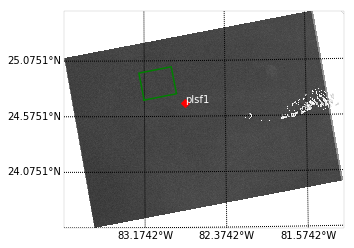

In [5]:
map_.drawcoastlines(linewidth=0.1)
map_.imshow(-10*np.log10(im),origin='upper',cmap='gray')
parallels=np.arange(np.min(lat), np.max(lat), 0.5)
map_.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(lon), np.max(lon), 0.8)
map_.drawmeridians(meridians,labels=[0,0,0,1])
map_.drawmapboundary(fill_color='white', linewidth=0.1)
map_.plot(int(x), int(y), marker='D', color='r')
map_.plot(np.around(xx), np.around(yy),'g-')
plt.text(int(x+10), int(y+10), 'plsf1', color='white')
plt.savefig('./2.png', dpi=400)

In [23]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170520T001818_20170520T001843_016658_01BA5D_566B.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]
from PIL import Image
image = Image.fromarray(sigma_vv)
out = image.transpose(Image.FLIP_TOP_BOTTOM)
out = out.rotate(10.5, expand=1)
im = np.array(out)

In [24]:
map_ = Basemap(projection='stere',lat_0=np.max(lat),lon_0=np.min(lon),\
            llcrnrlat=np.min(lat) ,urcrnrlat=np.max(lat),\
            llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), resolution='f')


In [25]:
x, y = map_(-94.033,29.683)


/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is d

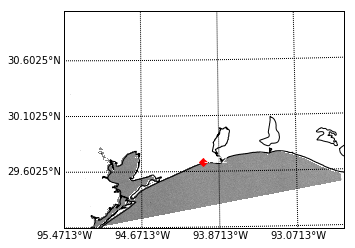

In [31]:
map_.drawcoastlines()
map_.imshow(-10*np.log10(im),origin='upper',cmap='gray')
parallels=np.arange(np.min(lat), np.max(lat), 0.5)
map_.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(lon), np.max(lon), 0.8)
map_.drawmeridians(meridians,labels=[0,0,0,1])
map_.drawmapboundary(fill_color='white')
map_.plot(int(x), int(y), marker='D', color='r')
plt.text(int(x-30), int(y+30), 'srst2', color='white')
plt.savefig('./3.png', dpi=400)

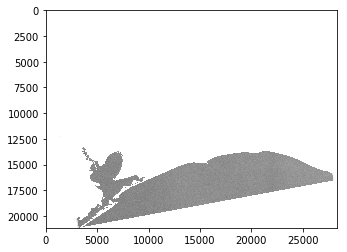

In [30]:
plt.imshow(-10*np.log10(im), 'gray')

In [4]:
sub_lat = lat[10200:14000,15800:20500]
sub_lon = lon[10200:14000,15800:20500]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0],sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0],sub_lon[0,0]]

In [8]:
sub_lat[-1,-1]

36.380169

In [9]:
sub_lat[-1, 0]

36.309032

In [121]:

sub_lat = lat[9800:14210,15950:20360]
sub_lon = lon[9800:14210,15950:20360]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0],sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0],sub_lon[0,0]]
sub = sigma_vv[9800:14210,15950:20360]

dire_ = direction.get_dir(sub, sub_size=500, remove_ambi = True, ndbc_= ndbc_dire)

sub_size=500
sub_size_h = int(sub_size/2)
shape_x = sub.shape[0]
shape_y = sub.shape[1]
x_, y_ = np.arange(sub_size_h, shape_x-sub_size_h, sub_size), np.arange(sub_size_h, shape_y-sub_size_h, sub_size)
points = np.meshgrid(x_, y_)
X, Y = map_1(sub_lon[points], sub_lat[points])

image1 = Image.fromarray(sub)
out1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
out1 = out1.rotate(351, expand=1)
sub= np.array(out1)



map_1 = Basemap(projection='stere',lat_0=np.max(sub_lat),lon_0=np.min(sub_lon),\
            llcrnrlat=np.min(sub_lat) ,urcrnrlat=np.max(sub_lat),\
            llcrnrlon=np.min(sub_lon),urcrnrlon=np.max(sub_lon), resolution='f')


index = 0
color_list = [(1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]








/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

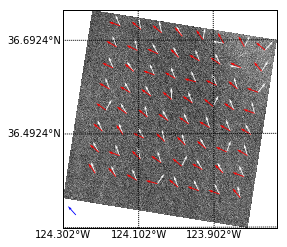

In [126]:
map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')
index=0
for d in dire_:
    U1 = 20*np.sin((280-d)%360/180*np.pi)
    V1 = 20*np.cos((280-d)%360/180*np.pi)
    map_1.quiver(X, Y, U1[points], V1[points], width=0.004, color=color_list[index])
    index+=1
map_1.quiver([[3000]], [3000], [[20*np.sin(318/180*np.pi)]], [[20*np.cos(318/180*np.pi)]], width=0.004, color=(0,0, 1))
plt.savefig('./1_wind_5.png', dpi=400)

In [124]:
ndbc_dire = (190-318+90)%360
ww3 = Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)

t1:29.036243
t2:61.614424
t1:19.036243
t2:53.443191
t1:49.036243
t2:59.406685
t1:49.036243
t2:7.765166
t1:39.036243
t2:7.696052
t1:9.036243
t2:47.468118
t1:44.036243
t2:300.963757
t1:29.036243
t2:4.398705
t1:34.036243
t2:0.000000
t1:39.036243
t2:0.000000
t1:9.036243
t2:300.963757
t1:34.036243
t2:4.573921
t1:44.036243
t2:0.000000
t1:29.036243
t2:47.468118
t1:39.036243
t2:4.398705
t1:14.036243
t2:30.963757
t1:39.036243
t2:0.000000
t1:54.036243
t2:2.726311
t1:34.036243
t2:0.000000
t1:34.036243
t2:4.573921
t1:19.036243
t2:9.637538
t1:24.036243
t2:7.696052
t1:39.036243
t2:0.000000
t1:29.036243
t2:19.653824
t1:34.036243
t2:7.696052
t1:49.036243
t2:59.406685
t1:49.036243
t2:7.765166
t1:39.036243
t2:7.696052
t1:39.036243
t2:4.398705
t1:49.036243
t2:2.726311
t1:29.036243
t2:4.398705
t1:34.036243
t2:0.000000
t1:39.036243
t2:0.000000
t1:44.036243
t2:41.268603
t1:24.036243
t2:7.696052
t1:44.036243
t2:0.000000
t1:29.036243
t2:47.468118
t1:39.036243
t2:4.398705
t1:29.036243
t2:8.841815
t1:39.036243


/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

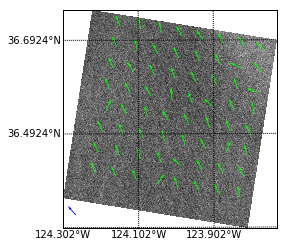

In [127]:
d = ww3
U1 = 20*np.sin((280-d)%360/180*np.pi)
V1 = 20*np.cos((280-d)%360/180*np.pi)

map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')

map_1.quiver(X, Y, U1, V1, width=0.004, color=(0, 1, 0))
map_1.quiver([[3000]], [3000], [[20*np.sin(318/180*np.pi)]], [[20*np.cos(318/180*np.pi)]], width=0.004, color=(0,0, 1))
plt.savefig('./1_wind_m_5.png', dpi=400)

plot new d58f

In [10]:
ndbc_dire = (350-97+90)%360
sub_lat = lat[11400:14100,7150:10450]
sub_lon = lon[11400:14100,7150:10450]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0],sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0],sub_lon[0,0]]
sub = sigma_vv[11400:14100,7150:10450]

dire_ = direction.get_dir(sub, sub_size=100, remove_ambi = True, ndbc_= ndbc_dire)

sub_size=100
sub_size_h = int(sub_size/2)
shape_x = sub.shape[0]
shape_y = sub.shape[1]
x_, y_ = np.arange(sub_size_h, shape_x-sub_size_h, sub_size), np.arange(sub_size_h, shape_y-sub_size_h, sub_size)
points = np.meshgrid(x_, y_)

image1 = Image.fromarray(sub)
out1 = image1.transpose(Image.FLIP_TOP_BOTTOM)
out1 = out1.rotate(10.5, expand=1)
sub= np.array(out1)

map_1 = Basemap(projection='stere',lat_0=np.max(sub_lat),lon_0=np.min(sub_lon),\
            llcrnrlat=np.min(sub_lat) ,urcrnrlat=np.max(sub_lat),\
            llcrnrlon=np.min(sub_lon),urcrnrlon=np.max(sub_lon), resolution='f')
X, Y = map_1(sub_lon[points], sub_lat[points])

index = 0
color_list = [(1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

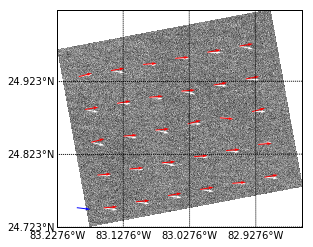

In [7]:
map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.1)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.1)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')
index=0
for d in dire_:
    U1 = 20*np.sin((80-d)%360/180*np.pi)
    V1 = 20*np.cos((80-d)%360/180*np.pi)
    map_1.quiver(X, Y, U1[points], V1[points], width=0.004, color=color_list[index])
    index+=1
map_1.quiver([[3000]], [3000], [[20*np.sin(97/180*np.pi)]], [[20*np.cos(97/180*np.pi)]], width=0.004, color=(0,0, 1))
plt.savefig('./2_wind_2.png', dpi=400)

In [19]:
import direction
ww3 = direction.Median_filter(w1=ww3, w2=dire_[1][points], b=ndbc_dire, filter_size=4)
d = ww3

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

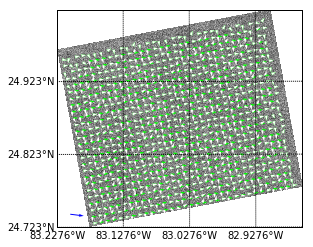

In [24]:
d=ww3
U1 = 20*np.sin((80-d)%360/180*np.pi)
V1 = 20*np.cos((80-d)%360/180*np.pi)

map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.1)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.1)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')


map_1.quiver(X, Y, U1, V1, width=0.004, color=(0, 1, 0))
d=dire_[0]
U1 = 20*np.sin((80-d)%360/180*np.pi)
V1 = 20*np.cos((80-d)%360/180*np.pi)
map_1.quiver(X, Y, U1[points], V1[points], width=0.004, color=(1,1,1))
map_1.quiver([[2000]], [2000], [[20*np.sin(97/180*np.pi)]], [[20*np.cos(97/180*np.pi)]], width=0.004, color=(0,0, 1))
plt.savefig('./2_wind_a_1_3.png', dpi=400)